# The only input needed to run everything is the `.h5` file!


## Imports

In [16]:
# To make sure we can import h5utils.py from the notebooks folder
import sys
sys.path.append('../')

import utils.h5_utils as h5
from scripts import new_optoplots

import os
import shutil
import glob
import json
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import npyx

import plotly.graph_objects as go
import plotly.express as px

from io import BytesIO
import matplotlib.pyplot as plt
import base64

from IPython.display import clear_output

from datetime import date

from utils.constants import CORRESPONDENCE

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
#! Important note: central range is set to 82 because that is the default for dsmatch! So same as our features!
N_CHANNELS = 10
CENTRAL_RANGE = 82

In [19]:
N_TEMPORAL_FEATURES = 15

home = str(Path.home())
DATA_PATH = home + "/Desktop/new_hull.h5"

BASE_DATASET = h5.NeuronsDataset(
    DATA_PATH,
    quality_check=False,
    normalise_wvf=False,
    n_channels=N_CHANNELS,
    central_range=CENTRAL_RANGE,
    # _label="expert_label"
    _use_amplitudes=True,
)

BASE_DATASET.make_labels_only()


Reading dataset:   0%|          | 0/54 [00:00<?, ?it/s]

54 neurons loaded, of which labelled: 54 
0 neurons discarded, of which labelled: 0. More details at the 'discarded_df' attribute.


## Dataset creation

Feature dataset:

Create if new or load if existing

In [20]:
def h5_feature_extraction(
    dataset: h5.NeuronsDataset, save_path=None, ignore_exceptions=False
):
    """
    It takes a NeuronsDataset instance coming from an h5 dataset and extracts the features.

    Params:

        dataset: NeuronsDataset instance
        save_path: where to save the csv file

    Returns:

        A dataframe with all the features for all the cells in the dataset.
        This will include:
            - neuron information (optolabel, data_path, unit)
            - temporal features (15)
            - waveform features (18)
    """

    columns = [
        "label",
        "dp",
        "unit",
        "mfr",
        "mifr",
        "med_isi",
        "mode_isi",
        "prct5ISI",
        "entropy",
        "CV2_mean",
        "CV2_median",
        "CV",
        "IR",
        "Lv",
        "LvR",
        "LcV",
        "SI",
        "SKW",
        "relevant_channel",
        "trough_voltage",
        "trough_t",
        "peak_voltage",
        "peak_t",
        "repolarisation_t",
        "depolarisation_t",
        "peak_50_width",
        "trough_50_width",
        "onset_t",
        "onset_amp",
        "wvf_width",
        "peak_trough_ratio",
        "recovery_slope",
        "repolarisation_slope",
        "depolarisation_slope",
        "spatial_decay_24um",
        "dendritic_comp_amp",
    ]

    feat_df = pd.DataFrame(columns=columns)

    for i in tqdm(range(len(dataset)), desc="Extracting features"):
        dp = "/".join(dataset.info[i].split("/")[:-1])
        unit = int(dataset.info[i].split("/")[-1])
        label = CORRESPONDENCE[dataset.targets[i]]
        waveform = dataset.wf[i].reshape(dataset._n_channels, dataset._central_range)
        spike_train = dataset.spikes_list[i]
        try:
            wvf_features = npyx.feat.new_waveform_features(waveform.T, dataset._n_channels//2)
            tmp_features = npyx.feat.temp_feat(spike_train)

            curr_feat = [label, dp, unit, *tmp_features, *wvf_features]
            feat_df = feat_df.append(dict(zip(columns, curr_feat)), ignore_index=True)

        except Exception as e:
            exc_type, _, exc_tb = sys.exc_info()
            print(
                f"Something went wrong for the feature computation of neuron {i} (unit {unit} in {dp})"
            )
            print(f"{exc_type} at line {exc_tb.tb_lineno}: {e}")
            if ignore_exceptions:
                curr_feat = np.zeros(len(columns))
                feat_df = feat_df.append(dict(zip(columns, curr_feat)), ignore_index=True)
                continue
            else:
                raise
            
    feat_df = feat_df.infer_objects()
    if save_path is None:
        save_path = os.getcwd()
        today = date.today().strftime("%b-%d-%Y")
        feat_df.to_csv(os.path.join(save_path, f"{today}_all_features.csv"))
    else:
        feat_df.to_csv(save_path)

    return feat_df

df = h5_feature_extraction(BASE_DATASET, ignore_exceptions=True)

Extracting features:   0%|          | 0/54 [00:00<?, ?it/s]

In [6]:
test_wave = (BASE_DATASET.wf[919].reshape(10, 82))
relevant_waveform, somatic, relevant_channel = npyx.feat.find_relevant_waveform(
        test_wave, 11
    )
relevant_waveform = npyx.feat.interp_wave(relevant_waveform)

peak_times, peak_values = npyx.feat.detect_peaks(-relevant_waveform, plot_debug=True)

IndexError: index 919 is out of bounds for axis 0 with size 0

In [ ]:
first_trough_t, first_peak_t = npyx.feat.find_relevant_peaks(peak_times, peak_values, 0.8 * np.std(relevant_waveform))

In [7]:
first_trough_t

NameError: name 'first_trough_t' is not defined

In [8]:
first_peak_t

NameError: name 'first_peak_t' is not defined

In [63]:
CORRESPONDENCE

{5: 'PkC_cs',
 4: 'PkC_ss',
 3: 'MFB',
 2: 'MLI',
 1: 'GoC',
 0: 'GrC',
 -1: 'unlabelled'}

In [59]:
pd.Series(BASE_DATASET.targets).replace(CORRESPONDENCE).value_counts()

PkC_ss    205
GoC       188
PkC_cs    144
MFB        86
MLI        22
dtype: int64

In [66]:
CORRESPONDENCE

{5: 'PkC_cs',
 4: 'PkC_ss',
 3: 'MFB',
 2: 'MLI',
 1: 'GoC',
 0: 'GrC',
 -1: 'unlabelled'}

In [65]:
np.unique(BASE_DATASET.targets, return_counts=True)

(array([1, 2, 3, 4, 5]), array([188,  22,  86, 205, 144]))

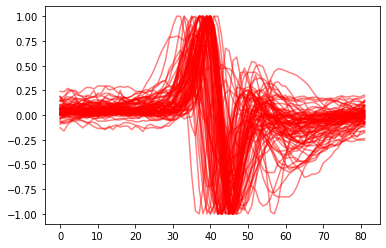

86

In [67]:
cnt=0
for i, wf in enumerate(BASE_DATASET.wf):
    if BASE_DATASET.targets[i] == 3:
        cnt+=1
        wf_image = wf.reshape(10, 82)
        peak_channel = np.argmin(np.ptp(wf_image, axis = 1))
        peak_wf = wf_image[peak_channel]
        peak_wf = peak_wf / np.max(np.abs(peak_wf))
        plt.plot(peak_wf, color="red", alpha=0.5)
plt.show()
cnt


In [66]:
df['label'].value_counts()

MFB       18
PkC_ss    18
MLI       13
PkC_cs     5
Name: label, dtype: int64

In [4]:
df = pd.read_csv('Oct-21-2022_all_features.csv')

# Plotting dataset:

In [6]:
def show_named_plotly_colours():
    """
    function to display to user the colours to match plotly's named
    css colours.

    Reference:
        #https://community.plotly.com/t/plotly-colours-list/11730/3

    Returns:
        plotly dataframe with cell colour to match named colour name

    """
    s='''
        aliceblue, antiquewhite, aqua, aquamarine, azure,
        beige, bisque, black, blanchedalmond, blue,
        blueviolet, brown, burlywood, cadetblue,
        chartreuse, chocolate, coral, cornflowerblue,
        cornsilk, crimson, cyan, darkblue, darkcyan,
        darkgoldenrod, darkgray, darkgrey, darkgreen,
        darkkhaki, darkmagenta, darkolivegreen, darkorange,
        darkorchid, darkred, darksalmon, darkseagreen,
        darkslateblue, darkslategray, darkslategrey,
        darkturquoise, darkviolet, deeppink, deepskyblue,
        dimgray, dimgrey, dodgerblue, firebrick,
        floralwhite, forestgreen, fuchsia, gainsboro,
        ghostwhite, gold, goldenrod, gray, grey, green,
        greenyellow, honeydew, hotpink, indianred, indigo,
        ivory, khaki, lavender, lavenderblush, lawngreen,
        lemonchiffon, lightblue, lightcoral, lightcyan,
        lightgoldenrodyellow, lightgray, lightgrey,
        lightgreen, lightpink, lightsalmon, lightseagreen,
        lightskyblue, lightslategray, lightslategrey,
        lightsteelblue, lightyellow, lime, limegreen,
        linen, magenta, maroon, mediumaquamarine,
        mediumblue, mediumorchid, mediumpurple,
        mediumseagreen, mediumslateblue, mediumspringgreen,
        mediumturquoise, mediumvioletred, midnightblue,
        mintcream, mistyrose, moccasin, navajowhite, navy,
        oldlace, olive, olivedrab, orange, orangered,
        orchid, palegoldenrod, palegreen, paleturquoise,
        palevioletred, papayawhip, peachpuff, peru, pink,
        plum, powderblue, purple, red, rosybrown,
        royalblue, saddlebrown, salmon, sandybrown,
        seagreen, seashell, sienna, silver, skyblue,
        slateblue, slategray, slategrey, snow, springgreen,
        steelblue, tan, teal, thistle, tomato, turquoise,
        violet, wheat, white, whitesmoke, yellow,
        yellowgreen
        '''
    li=s.split(',')
    li=[l.replace('\n','') for l in li]
    li=[l.replace(' ','') for l in li]

    import pandas as pd
    import plotly.graph_objects as go

    df=pd.DataFrame.from_dict({'colour': li})
    fig = go.Figure(data=[go.Table(
      header=dict(
        values=["Plotly Named CSS colours"],
        line_color='black', fill_color='white',
        align='center', font=dict(color='black', size=14)
      ),
      cells=dict(
        values=[df.colour],
        line_color=[df.colour], fill_color=[df.colour],
        align='center', font=dict(color='black', size=11)
      ))
    ])

    fig.show()
show_named_plotly_colours()

In [21]:
def make_plotting_df(df: pd.DataFrame, save: bool = True, save_path: str = None) -> pd.DataFrame:
    dataframe = df.copy()
    colors_dict = {
        "PkC_cs": "orangered",
        "PkC_ss": "darkblue",
        "GoC": "darkgreen",
        "GrC": "saddlebrown",
        "MLI": "crimson",
        "MFB": "indigo",
    }
    # colors_dict = {
    #     "PkC_cs": "orange",
    #     "PkC_ss": "blue",
    #     "GoC": "green",
    #     "GrC": "brown",
    #     "MLI": "red",
    #     "MFB": "purple",
    # }
    # Add an 'absolute id' like column for plotting purposes, so that each neuron has an unique identifier
    abs_id = np.arange(len(dataframe))
    
    #! Mind this hacky thing
    abs_id = np.array(["101" + str(x) for x in abs_id], dtype=int)
    dataframe.insert(loc=0, column="plotting_id", value=abs_id)
    
    new_df = pd.DataFrame(
        columns=[
            "label",
            "feature",
            "normalised_value",
            "raw_value",
            "dp",
            "unit",
            "color",
            "plotting_id",
        ]
    )

    # Why the hard-coded 4? The first 4 columns in the df are metadata (dp, unit, plotting_id, label)
    for i, column in enumerate(dataframe.columns[4:]):
        mean_data = (dataframe[column].to_numpy()).mean()
        std_data = (dataframe[column].to_numpy()).std()
        norm_data = (dataframe[column].to_numpy() - mean_data) / std_data
        raw_data = dataframe[column].to_numpy()
        labels = dataframe["label"].to_numpy()
        feature = [dataframe.columns[i + 4]] * len(norm_data)
        dp = dataframe["dp"].to_numpy()
        unit = dataframe["unit"].to_numpy()
        color = [colors_dict[label] for label in labels]
        plotting_id = dataframe["plotting_id"].to_numpy()
        
        feat_df = pd.DataFrame(
            {
                "label": labels,
                "feature": feature,
                "normalised_value": norm_data,
                "raw_value": raw_data,
                "dp": dp,
                "unit": unit,
                "color": color,
                "plotting_id": plotting_id,
            }
        )
        new_df = pd.concat([new_df, feat_df], ignore_index=True)

    # Finally assign color grey to neurons with invalid temporal features
    zero_temporal = new_df[new_df["raw_value"] == 0.]["unit"].value_counts()
    zero_units = (zero_temporal[zero_temporal>5]).index.to_numpy()
    new_df.loc[new_df["unit"].isin(zero_units), "color"] = "gray"
    
    # Save if the option is requested
    if save:
        today = date.today().strftime("%b-%d-%Y")
        if save_path is None:
            new_df.to_csv(f"{today}_dashboard_features.csv")
        else:
            new_df.to_csv(f"{save_path}/{today}_dashboard_features.csv")
    
    
    
    return new_df


In [22]:
all_features = make_plotting_df(df)

In [17]:
all_features

,label,feature,normalised_value,raw_value,dp,unit,color,plotting_id
0,PkC_ss,mfr,2.051858,125.656166,18-08-30_YC001_probe1,431,blue,0
1,PkC_ss,mfr,2.211343,132.470983,18-08-30_YC001_probe1,437,blue,1
2,PkC_ss,mfr,0.693383,67.608422,18-08-30_YC001_probe1,487,blue,2
3,PkC_ss,mfr,0.864402,74.916070,18-08-30_YC001_probe1,492,blue,3
4,PkC_ss,mfr,0.724644,68.944211,18-08-30_YC001_probe1,494,blue,4
...,...,...,...,...,...,...,...,...
3394,MLI,dendritic_comp_amp,-0.456639,3.095684,19-12-13_YC007_probe1,273,red,98
3395,MLI,dendritic_comp_amp,0.679416,35.147131,19-12-13_YC007_probe1,300,red,99
3396,MLI,dendritic_comp_amp,1.002273,44.255900,19-12-13_YC007_probe1,503,red,100
3397,MLI,dendritic_comp_amp,-0.473893,2.608879,22-08-13_MO042,420,red,101


## Plots generation

Includes: waveforms, acgs, features plots and amplitude plots.

In [9]:
def save_acg(spike_train, unit_n, save_name=None):
    if save_name is None:
        raise NotImplementedError("Please specify a save name")

    # Get the spike train in the spontaneous period that meets false positive and false negative criteria.
    
    if len(spike_train.ravel()) > 1:
        plt.figure()
        npyx.plot.plot_acg("hello", unit_n, train=spike_train, figsize=(5, 4.5))

        plt.savefig(f"{save_name}-acg.pdf", format="pdf")
        plt.close()
    else:
        fig = plt.figure()
        ax = fig.add_subplot()
        fig.subplots_adjust(top=0.85)
        ax.axis([0, 10, 0, 10])
        ax.text(
            3,
            5,
            "No usable train \n after quality checks",
            style="italic",
            bbox={"facecolor": "red", "alpha": 0.4, "pad": 10},
        )
        plt.savefig(f"{save_name}-acg.pdf", format="pdf", bbox_inches="tight")
        plt.close()


def save_wvf(waveform, save_name=None):
    if save_name is None:
        raise NotImplementedError("Please specify a save name")

    plt.figure()
    npyx.plot.plt_wvf(waveform, figh_inch=6, figw_inch=5)

    plt.savefig(f"{save_name}-wvf.pdf", format="pdf", bbox_inches="tight")
    plt.close()


def save_feat(waveform, save_name=None):
    plt.rcParams["figure.figsize"] = [3.50, 2.50]
    plt.rcParams["figure.autolayout"] = True
    
    if save_name is None:
        raise NotImplementedError("Please specify a save name")

    wave, somatic, channel = npyx.feat.find_relevant_waveform(waveform, N_CHANNELS//2)

    plt.figure()
    npyx.feat.plot_all(wave)

    plt.savefig(f"{save_name}-feat.pdf", format="pdf", bbox_inches="tight")
    plt.close()

def save_amplitudes(times, amplitudes, dpi=300, save_name=None):
    
    if save_name is None:
        raise NotImplementedError("Please specify a save name")
    
    #! Hacky duplicate handling (should be fixed in npyx)!!!
    if len(times) > len(amplitudes):
        times = times[:len(amplitudes)]
    if len(amplitudes) > len(times):
        amplitudes = amplitudes[:len(times)]
        
    fig, ax = plt.subplots(1,2, figsize=(12, 5), sharey=True,  gridspec_kw={'width_ratios': [3, 1]})
    ax[0].plot(times / (30000 * 60), amplitudes, marker="o", markersize=2, linestyle="None")
    ax[0].set_xlabel("Time (min)")
    ax[0].set_ylabel(r"Amplitude ($\mu$V)")
    ax[0].spines["top"].set_visible(False)
    ax[0].spines["right"].set_visible(False)

    ax[1].hist(amplitudes, bins=200, orientation="horizontal")
    ax[1].set_xlabel("Count")
    ax[1].spines["top"].set_visible(False)
    ax[1].spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig(f"{save_name}-amplitudes.png", format="png", dpi=dpi, bbox_inches="tight")
    plt.close()

In [24]:
for plotting_id in tqdm(all_features["plotting_id"].unique()):
    save_id = plotting_id
    plotting_id = int(str(plotting_id)[3:])
    spike_train = BASE_DATASET.spikes_list[plotting_id]
    waveform = BASE_DATASET.wf[plotting_id].reshape(N_CHANNELS, CENTRAL_RANGE)
    amplitudes = BASE_DATASET.amplitudes_list[plotting_id]
    save_acg(spike_train, int(plotting_id), save_name = f"{str(save_id)}")
    save_wvf(waveform.T, save_name = f"{str(save_id)}")
    save_feat(waveform, save_name = f"{str(save_id)}")
    save_amplitudes(spike_train, amplitudes, save_name = f"{str(save_id)}")
clear_output(wait=True)

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

<Figure size 252x180 with 0 Axes>

In [52]:
waveform = h5.get_neuron_attr(DATA_PATH, 1, "mean_waveform_preprocessed")

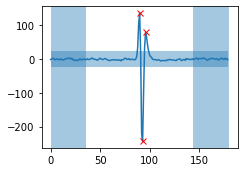

(array([90, 93, 96]), array([ 136.5234375, -243.75     ,   79.453125 ]))

In [68]:
wave, _, _ = npyx.feat.find_relevant_waveform(waveform, 10)
npyx.feat.detect_peaks(wave, plot_debug=True)

In [57]:
a = np.array([1,2,3])

In [55]:
np.min(wave)

-42.0703125

## Retrieve opto-plots
## REQUIRES SERVER ACCESS!

In [11]:
def fast_scandir(dirname, depth = 0):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        if depth < 3:
            subfolders.extend(fast_scandir(dirname, depth=depth+1))
    return subfolders

In [12]:
recordings_folders = fast_scandir("/media/npyx/4TB_ssd1/optag_recordings/")

In [13]:
def copy_opto_plots(dp, unit, all_server_recordings, save_name=None):
    if save_name is None:
        save_name = str(unit)
    global fail_list
    recording_detailed = dp.split('/')[-1]
    # recording_generic = dp.split('/')[-2]
    server_path = None
    for path in all_server_recordings:
        if recording_detailed in path:
            server_path = path
            break
            
            
    # if server_path is None:
    #     for path in all_server_recordings:
    #         if recording_generic in path:
    #             server_path = path
    #             break
    if server_path is None:
        print('------\n', dp, unit, '\n------')
        fail_list.append([dp, unit])
        return dp, unit
    
    try:
        server_image_path = server_path + f'/opto_plots/{unit}_plots_combined.pdf'
        target = f'{save_name}_opto_plots_combined.pdf'
        shutil.copyfile(server_image_path, target)
    except FileNotFoundError:
        if server_path == '/mnt/MB_server/npix_data/optotagging/Back-Up-YYC_2019_optotagging/data/GoC/20-11-05_DK215':
            server_image_path = f'/mnt/MB_server/npix_data/optotagging/Back-Up-YYC_2019_optotagging/data/GoC/20-11-05_DK215/20-11-05_DK215_g0/20-11-05_DK215_g0_imec0/opto_plots/{unit}_plots_combined.pdf'
        elif server_path == '/mnt/MB_server/npix_data/optotagging/Back-Up-YYC_2019_optotagging/data/GoC/20-03-06_DK186':
            if dp.split("/")[-1] == '20-03-06_DK186_probe1':
                server_image_path = f'/mnt/MB_server/npix_data/optotagging/Back-Up-YYC_2019_optotagging/data/GoC/20-03-06_DK186/DK186_GoC_run1_g0/DK186_GoC_run1_g0_imec0/ArtSubKS2.0_2/opto_plots/{unit}_plots_combined.pdf'
            else:
                server_image_path = f'/mnt/MB_server/npix_data/optotagging/Back-Up-YYC_2019_optotagging/data/GoC/20-03-06_DK186/DK186_GoC_run1_g0/DK186_GoC_run1_g0_imec1/ArtSubKS2.0/opto_plots/{unit}_plots_combined.pdf'
        elif server_path == '/mnt/MB_server/npix_data/optotagging/Back-Up-YYC_2019_optotagging/data/MFB/20-07-21_DK206':
            server_image_path = f"/mnt/MB_server/npix_data/optotagging/Back-Up-YYC_2019_optotagging/data/MFB/20-07-21_DK206/200721_DK206_MFB_g0/200721_DK206_MFB_g0_imec0/ArtSubKS2.0/opto_plots/{unit}_plots_combined.pdf"
        else:
            server_image_path = server_path + f'/ArtSubKS2.0/opto_plots/{unit}_plots_combined.pdf'
            
        target = f'{save_name}_opto_plots_combined.pdf'
        try:
            shutil.copyfile(server_image_path, target)
        except FileNotFoundError:
            print(server_image_path)
            fail_list.append([dp, unit])
            return dp, unit

Do the copying and save the datasets for which we failed

In [14]:
fail_list = []
for dp, unit, plotting_id in tqdm(zip(all_features['dp'].to_numpy()[:len(df)], all_features['unit'].to_numpy()[:len(df)], all_features['plotting_id'].to_numpy()[:len(df)]), total=len(df)):
    copy_opto_plots(dp, unit, recordings_folders, save_name=str(plotting_id))

  0%|          | 0/96 [00:00<?, ?it/s]

In [15]:
fail_list

[]

In [ ]:
today = date.today().strftime("%b-%d-%Y")
h5.save(f'{today}-fail_list.pkl', fail_list)

# Alternative opto plot scripts:

Re-calculates the opto-plots for every neuron in the json file and saves it locally here.

In [44]:
def re_plot_opto_plots(json_path, overwrite=False):
    with open(json_path) as f:
        json_f = json.load(f)

    # Check the json and do the optoplots at the same time
    for dataset in tqdm(json_f.values(), desc='Re-plotting opto plots'):
        data_path = dataset["dp"]
        dp = Path(data_path)
        
        if not dp.exists():
            print(f"\033[31;1m{dp} doesn't exist!!\033[0m")
            continue

        units=dataset['units']
        ss=dataset['ss']
        cs=dataset['cs']
        all_units = units + ss + cs
        all_units_str = ' '.join(map(str, all_units))
        
        if "YC012" in data_path:
            animal_name = "YC012"
        elif "MO027" in data_path:
            animal_name = "MO027"
        elif "MO042" in data_path:
            animal_name = "MO042"
        else:
            animal_name = data_path.split("/")[-2].split("_")[-1]
        
        script_path = "/home/npyx/Dropbox/Notebooks/scripts/50ms-plots-faster.py"
        fig_dir = '/home/npyx/Dropbox/Notebooks/individual-plots'
        
        new_optoplots.make_plots(data_path, fig_dir, animal_name, 1, np.array(all_units), 'opto_plots', overwrite=overwrite)
        
        # os.system(f"conda run -n npyx python {script_path} -dp '{data_path}' -save-dir 'opto_plots' -fig-dir '{fig_dir}' -mouse '{animal_name}' -startstim 1 -which 'good' --units {all_units_str}")


In [ ]:
re_plot_opto_plots(json_path)

## Generate SVG files and move them to desktop

In [25]:
# Move amplitudes png plots to Desktop SVG folder

home = str(Path.home())

if not os.path.isdir(f"{home}/Desktop/SVGs_SfN"):
    os.mkdir(f"{home}/Desktop/SVGs_SfN")

for file in tqdm(glob.glob("*amplitudes.png")):
    filename = file.split(".")[0]
    os.system(f"mv {file} {home}/Desktop/SVGs_SfN")

  0%|          | 0/150 [00:00<?, ?it/s]

In [26]:
home = str(Path.home())

if not os.path.isdir(f"{home}/Desktop/SVGs_SfN"):
    os.mkdir(f"{home}/Desktop/SVGs_SfN")

for file in tqdm(glob.glob("*.pdf")):
    filename = file.split(".")[0]
    if "opto_plots" in file:
        os.system(f"convert -units PixelsPerInch -density 288 {file} {filename}.png ")
        os.system(f"mv {filename}.png {home}/Desktop/SVGs_SfN")
    else:
        os.system(f"pdf2svg {file} {filename}_big.svg 1")
        os.system(f"svgo {filename}_big.svg -o {filename}.svg")
        os.system(f"rm {filename}_big.svg")
        os.system(f"mv {filename}.svg {home}/Desktop/SVGs_SfN")
        pass


  0%|          | 0/547 [00:00<?, ?it/s]


39-acg_big.svg:
Done in 276 ms!
71.4 KiB - 58% = 29.953 KiB

10142-wvf_big.svg:
Done in 197 ms!
41.789 KiB - 49.1% = 21.263 KiB

77-acg_big.svg:
Done in 202 ms!
36.983 KiB - 46.7% = 19.728 KiB

7-wvf_big.svg:
Done in 191 ms!
42.812 KiB - 48.8% = 21.904 KiB

62-acg_big.svg:
Done in 312 ms!
69.98 KiB - 58.1% = 29.324 KiB

10128-feat_big.svg:
Done in 338 ms!
57.886 KiB - 45% = 31.843 KiB

45-feat_big.svg:
Done in 310 ms!
53.529 KiB - 45.3% = 29.27 KiB

44-feat_big.svg:
Done in 311 ms!
54.542 KiB - 44.7% = 30.156 KiB

67-feat_big.svg:
Done in 326 ms!
54.086 KiB - 44.8% = 29.84 KiB

10120-wvf_big.svg:
Done in 267 ms!
44.408 KiB - 49% = 22.637 KiB

1-acg_big.svg:
Done in 365 ms!
66.495 KiB - 59.2% = 27.105 KiB

64-acg_big.svg:
Done in 311 ms!
88.744 KiB - 61.5% = 34.146 KiB

54-feat_big.svg:
Done in 341 ms!
53.449 KiB - 45% = 29.397 KiB

12-acg_big.svg:
Done in 302 ms!
89.161 KiB - 61.1% = 34.656 KiB

10129-acg_big.svg:
Done in 266 ms!
71.786 KiB - 58.4% = 29.895 KiB

10123-feat_big.svg:
Do

## Filter PkC CS and SS pairs that are not optotagged

In [51]:
with open(json_path) as f:
    json_f = json.load(f)
simple_and_complex = []
for key in json_f:
    simple_and_complex.extend(json_f[key]["ss"])
    simple_and_complex.extend(json_f[key]["cs"])

In [52]:
not_optotagged = df.loc[df["unit"].isin(simple_and_complex), ["label", "dp", "unit", "plotting_id"]]

In [ ]:
today = date.today().strftime("%b-%d-%Y")
not_optotagged.to_csv(f"{today}-not_optotagged.csv")

### Here manual curation is needed to add the corresponding pairs to the json file!
See [here](https://docs.google.com/spreadsheets/d/14-IJPxhNrgPPapYODdag7BbuVSprwdH8q35Z2QVaG_Y/edit#gid=1741211396)

After editing manually we can remove the non optotagged optoplots and change them for what we actually want

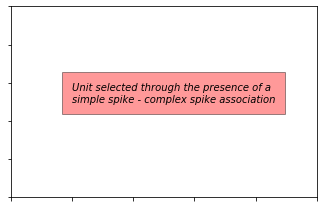

In [29]:
fig = plt.figure(figsize=(4.6, 3))
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)
ax.axis([0, 10, 0, 10])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(
    2,
    5,
    "Unit selected through the presence of a \n"
    "simple spike - complex spike association",
    style="italic",
    bbox={"facecolor": "red", "alpha": 0.4, "pad": 10},
)
# plt.show()
plt.savefig("purkinje_cell.pdf", format="pdf")

In [30]:
os.system(f"convert -units PixelsPerInch -density 288 purkinje_cell.pdf purkinje_cell.png ")
os.system(f"mv purkinje_cell.png {home}/Desktop/SVGs_SfN")

0

In [38]:
# Remove opto plots of non light responsive cells
for i, row in not_optotagged.iterrows():
    unit = row["unit"]
    plotting_id = str(row["plotting_id"])
    os.system(f"rm {plotting_id}_opto_plots_combined.pdf")
    fig = plt.figure(figsize=(4.6, 3))
    ax = fig.add_subplot()
    fig.subplots_adjust(top=0.85)
    ax.axis([0, 10, 0, 10])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.text(
        2,
        5,
        "Unit selected through the presence of a \n"
        "simple spike - complex spike association",
        style="italic",
        bbox={"facecolor": "red", "alpha": 0.4, "pad": 10},
    )
    pdf_file = f"{plotting_id}_opto_plots_combined.pdf"
    filename =  f"{plotting_id}_opto_plots_combined"
    plt.savefig(pdf_file, format="pdf")
    plt.close()
    os.system(f"convert -units PixelsPerInch -density 288 {pdf_file} {filename}.png ")
    os.system(f"mv {filename}.png {home}/Desktop/SVGs_SfN")

rm: cannot remove '103_opto_plots_combined.pdf': No such file or directory
rm: cannot remove '104_opto_plots_combined.pdf': No such file or directory
rm: cannot remove '105_opto_plots_combined.pdf': No such file or directory
rm: cannot remove '106_opto_plots_combined.pdf': No such file or directory


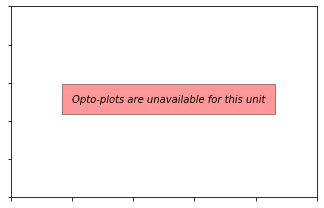

In [27]:
fig = plt.figure(figsize=(4.6, 3))
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)
ax.axis([0, 10, 0, 10])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(
    2,
    5,
    "Opto-plots are unavailable for this unit",
    style="italic",
    bbox={"facecolor": "red", "alpha": 0.4, "pad": 10},
)
plt.savefig("opto_plots_unavailable.pdf", format="pdf")